# Black-Litterman model for portfolio allocation

Now that we are familiarized with both mean-variance optimization and Bayesian inference, we can take a look at one of the most important models in finance: the Black-Litterman (B-L) model. There are many different implementations for the B-L model, and our main reference shall be Idzorek (2007).

The Black-Litterman model is a combination of both ideas: it relies on return data in order to find optimal portfolio allocations, however it allows for the incorporation of investors' opinions about future returns. This is done in a Bayesian setting via prior distributions.

The B-L formula for estimated mean returns is

$\hat{\mu}_{BL} = [(\tau \Sigma)^{-1} + P' \Omega^{-1} P]^{-1} [(\tau \Sigma)^{-1} \Pi + P' \Omega^{-1} Q]$.

Now let's break it down. First of all, the B-L model does not use the historical (sample) mean returns as the prior estimate of mean returns, as it tends to produce extreme long and short positions in unconstrained settings due to sample uncertainty. Instead, it relies on implied market equilibrium returns, $\Pi$, as the prior estimate for mean returns. The formula for $\Pi$ consists of

$\Pi = \lambda \Sigma w_{mkt}$.

Starting with the more simple parameters, $\Sigma$ is the sample covariance matrix of the excess (i.e. observed minus risk-free rate) returns and $w_{mkt}$ is the market capitalization weight of all assets. $\lambda$ is the market price of risk, calculated by dividing the mean of excess returns of the market portfolio by its variance:

$\lambda = \frac{r_m - r_f}{\sigma^2}$.

With all three components, we can obtain the values for $\Pi$, an $N \times 1$ vector where $N$ is our number of assets.

In [53]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = yf.download("QQQ SCHP SPY XLE XLF", start="2015-01-01", end="2022-01-01")["Close"]
risk_free = yf.download("^IRX", start="2015-01-01", end="2022-01-01")["Close"]

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed


In [54]:
tickers = ["QQQ", "SCHP", "SPY", "XLE", "XLF"]
assets_volume = np.empty(len(tickers))
for i in range(0,len(tickers)):
    assets_volume[i] = yf.Ticker(tickers[i]).info["totalAssets"]

assets_volume # obtaining market capitalizations that will be used to compute w_mkt

array([2.20519727e+11, 1.16118569e+10, 4.36436107e+11, 3.75002071e+10,
       3.25665423e+10])

In [55]:
w_mkt = assets_volume/np.sum(assets_volume)
w_mkt

array([0.29855056, 0.01572071, 0.59086888, 0.05076964, 0.0440902 ])

In [56]:
data.head()

,QQQ,SCHP,SPY,XLE,XLF
Date,,,,,
2015-01-02,102.940002,54.509998,205.429993,79.529999,20.089357
2015-01-05,101.430000,54.560001,201.720001,76.239998,19.666937
2015-01-06,100.070000,54.599998,199.820007,75.120003,19.366369
2015-01-07,101.360001,54.599998,202.309998,75.279999,19.569456
2015-01-08,103.300003,54.580002,205.899994,76.970001,19.861900


In [57]:
mkt_portfolio_returns = data.pct_change().dropna() @ w_mkt
# multiply by 252 so we get annualized mean and variance
market_mean_returns = mkt_portfolio_returns.mean() * 252
market_var_returns = mkt_portfolio_returns.var() * 252
mean_risk_free = np.mean(risk_free)/100

lamb = (market_mean_returns - mean_risk_free)/market_var_returns
lamb

4.212895225332502

In [58]:
excess_returns = data.pct_change().dropna().sub(pd.DataFrame(risk_free[1:]/100)['Close'], axis=0)
Sigma = (excess_returns.cov() * 252).values
Sigma

array([[0.06281343, 0.01770594, 0.05301843, 0.05310712, 0.05194   ],
       [0.01770594, 0.0205251 , 0.01754405, 0.01939368, 0.01648125],
       [0.05301843, 0.01754405, 0.05022575, 0.05863181, 0.0550494 ],
       [0.05310712, 0.01939368, 0.05863181, 0.11825733, 0.07537013],
       [0.05194   , 0.01648125, 0.0550494 , 0.07537013, 0.07474093]])

In [59]:
Pi = lamb * (Sigma @ w_mkt)
Pi

array([0.23316078, 0.0745105 , 0.21563776, 0.25332443, 0.23345612])

## Incorporating subjective views

Now, with our prior estimates for the mean returns in hand, we can begin to incorporate the subjective views onto the Black-Litterman model. This is the purpose of matrices $Q$ and $P$.

Suppose we have the following subjective views:
* QQQ will rise 10%
* SPY will drop 5%
* XLE will outperform XLF by 8%

The first two are *absolute* views, and the last one is a *relative* view.

$Q$ is the $K \times 1$ matrix that contains these views, where $K$ is the number of views.

In [60]:
Q = np.array([0.1,-0.05,0.08])
Q

array([ 0.1 , -0.05,  0.08])

$P$ is the picking matrix, which will map the views onto the assets. It has dimensions $K \times N$.

For absolute views, the rows have $1$ for the corresponding asset and $0$ for all others. For relative views, it has positive numbers for the outperforming assets and negative numbers for the underperforming assets, with all numbers together adding up to zero.

In [61]:
P = np.array([[1,0,0,0,0],[0,0,1,0,0],[0,0,0,1,-1]]) # our assets are ordered QQQ, SCHP, SPY, XLE, XLF
P

array([[ 1,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0],
       [ 0,  0,  0,  1, -1]])

The last components of the Black-Litterman formula are the matrix $\Omega$ and the quantity $\tau$.

$\Omega$ is referred to as the confidence matrix, as it represents the uncertainty the investor has in their views. It is the covariance matrix of our views, meaning that our views are actually of the form $Q + \boldsymbol{\varepsilon}$, where $\boldsymbol{\varepsilon} \sim MVN(\boldsymbol{0}, \Omega)$

$\Omega$ is a diagonal matrix, as the views have zero correlation, i.e., are independent of each other. As it is quite difficult to summarise the uncertainty contained in each view, many methods for its calculation have been proposed. We shall stick to Idzorek's method, which allows for users to specify their confidence in each view as a percentage.

The original method by Idzorek estimates the view variances, $\omega_i$, via least squares. Walters (2014) proposes a closed-form method.

Denoting by $conf$ the confidence in each of our views, which can range from zero to 100%, we shall have

$\alpha = \frac{1-conf}{conf}$,

$\Omega = \tau \alpha P \Sigma P'$.

This leaves us with $\tau$. From the B-L formula we can see it is inversely proportional to the weight given to our prior estimate for the mean returns, $\Pi$. As $\Pi$ corresponds to market equilibrium returns, Idzorek cites that, since the uncertainty in the mean is reasonably lower than the uncertainty in the observed historical returns, $\tau$ should be close to zero. For the sake of simplicity, we set $\tau = 0.05$ for our example.

Assuming a confidence of 70%, 60% and 40% for each of the views, we can obtain $\Omega$:

In [62]:
conf = np.array([0.7, 0.6, 0.4])
tau = 0.05

alpha = (1-conf)/conf

Omega_diag = tau * (alpha @ (P @ Sigma @ P.T))
Omega = np.diag(Omega_diag)
Omega

array([[0.00320082, 0.        , 0.        ],
       [0.        , 0.00307898, 0.        ],
       [0.        , 0.        , 0.00331377]])

Now we can go back to the B-L formula and obtain the Black-Litterman posterior estimates for mean returns

$\hat{\mu}_{BL} = [(\tau \Sigma)^{-1} + P' \Omega^{-1} P]^{-1} [(\tau \Sigma)^{-1} \Pi + P' \Omega^{-1} Q]$.

In [63]:
mu_bl = np.linalg.inv(np.linalg.inv(tau*Sigma) + (P.T @ np.linalg.inv(Omega) @ P)) @ ((np.linalg.inv(tau*Sigma) @ Pi) + (P.T @ np.linalg.inv(Omega) @ Q))
mu_bl

array([0.10431744, 0.03368189, 0.09558585, 0.13826505, 0.10020411])

Compare with the historical mean returns::

In [64]:
data.pct_change().dropna().mean().values * 252

array([ 0.21554025,  0.02172902,  0.13575803, -0.00191245,  0.12299622])

The first part of the B-L formula for the mean returns, $[(\tau \Sigma)^{-1} + P' \Omega^{-1} P]^{-1}$, is actually the B-L posterior estimate of the returns covariance matrix.

In [65]:
cov_bl = np.linalg.inv(np.linalg.inv(tau*Sigma) + (P.T @ np.linalg.inv(Omega) @ P))
cov_bl.round(4)

array([[0.0012, 0.0003, 0.0009, 0.0008, 0.0008],
       [0.0003, 0.0008, 0.0003, 0.0003, 0.0003],
       [0.0009, 0.0003, 0.001 , 0.0012, 0.0011],
       [0.0008, 0.0003, 0.0012, 0.0033, 0.002 ],
       [0.0008, 0.0003, 0.0011, 0.002 , 0.0021]])

In order to find the allocation weights for the B-L model, we can just plug the posterior mean and covariance estimates into the regular mean-variance optimizer, or find the weights via reverse optimization

$w_{BL} = (\lambda \Sigma)^{-1} \hat{\mu}_{BL}$.

We can also normalize so that all weights add up to 1

In [66]:
w_bl = np.linalg.inv(lamb * Sigma) @ mu_bl
w_bl = w_bl/np.sum(w_bl)
w_bl

array([ 0.66824439,  0.0371813 ,  0.07021976,  0.47532902, -0.25097447])

The library PyPortfolioOpt contains straightforward implementations of the Black-Litterman procedures we have seen up to here:

In [67]:
from pypfopt import black_litterman, risk_models

# pypfopt only allows for constant risk-free rates, we shall use the mean of our sample
lamb = black_litterman.market_implied_risk_aversion((data @ w_mkt), risk_free_rate=mean_risk_free)
Pi = black_litterman.market_implied_prior_returns(assets_volume, lamb, Sigma, risk_free_rate=mean_risk_free)

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\pypfopt\black_litterman.py:44: RuntimeWarning: If cov_matrix is not a dataframe, market cap index must be aligned to cov_matrix
  warnings.warn(


In [68]:
lamb

4.322514609223805

In [69]:
Pi

array([0.24722048, 0.08444213, 0.22924152, 0.26790879, 0.24752351])

In [70]:
from pypfopt.black_litterman import BlackLittermanModel

cov_matrix = (data.pct_change().dropna().cov() * 252)
bl = BlackLittermanModel(cov_matrix, pi=Pi, Q=Q, P=P, omega=Omega, view_confidences=conf, tau=0.05, risk_free_rate=mean_risk_free)

mu_bl = bl.bl_returns()
mu_bl

QQQ     0.129588
SCHP    0.088461
SPY     0.125473
XLE     0.167288
XLF     0.129328
dtype: float64

## Conjugate priors versus MCMC

Now let's go back to the B-L formula:

$\hat{\mu}_{BL} = [(\tau \Sigma)^{-1} + P' \Omega^{-1} P]^{-1} [(\tau \Sigma)^{-1} \Pi + P' \Omega^{-1} Q]$

The reason we can obtain a closed-form expression for $\hat{\mu}_{BL}$ is because the Black-Litterman model makes use of conjugate priors.

The parameter we wish to make inference for is the vector of asset mean returns, or expected returns. 

Our prior distribution for the mean returns is a multivariate normal. The mean vector of that prior distribution is $\Pi$, which comes from market equilibrium, is calculated from the data. The prior covariance is $\tau \Sigma$, and $\Sigma$ is the sample covariance, also calculated from market return data.

The subjective investor views, which are the B-L "likelihood", also follow a multivariate normal distribution.

Bayesian conjugate analysis shows us that, a mean vector $\boldsymbol{\mu}$ of a multivariate normal distribution with covariance $\boldsymbol{\Sigma}$, with prior distribution

$\boldsymbol{\mu} \sim MVN(\boldsymbol{\mu}_0, \boldsymbol{\Sigma}_0)$,

shall have the posterior covariance

$\boldsymbol{\Sigma}_P = [\boldsymbol{\Sigma}_0^{-1} + n \boldsymbol{\Sigma}^{-1}]^{-1}$

and posterior mean

$\boldsymbol{\mu}_P = \boldsymbol{\Sigma}_P [\boldsymbol{\Sigma}_0^{-1} \boldsymbol{\mu}_0 + n \boldsymbol{\Sigma}^{-1} \mathbf{\bar{x}}]$, 

where $\mathbf{\bar{x}}$ is the sample mean. 

These expressions are similar to the B-L formula.

But what if we wanted to depart from the conjugate priors in the B-L framework?

MCMC allows us to do that. Schepel (2019) presents us with a few extensions of the B-L model, some making use of MCMC algorithms. Let's assume the first model to be estimated by MCMC is similar to the classical B-L model:

$\mu \sim N(\Pi, \tau \Sigma)$,

$Q|\mu \sim N(P\mu, \Omega)$,

$r \sim N(\mu, \Sigma)$.

In [72]:
import pymc as pm

with pm.Model() as model_normal:
    mu = pm.MvNormal('mu', mu = Pi, cov = (tau * Sigma), shape = 5)
    Q_p = pm.MvNormal('Q', mu = pm.math.dot(P, mu), cov = Omega, observed = Q, shape = 3)
    r = pm.MvNormal('returns', mu = mu, cov = Sigma, observed = data.pct_change().dropna().values)

    trace_normal = pm.sample(2000, tune=1000, target_accept=0.8, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 132 seconds.


In [73]:
import arviz as az

az.summary(trace_normal)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.004,0.006,-0.007,0.015,0.0,0.0,1520.0,2911.0,1.0
mu[1],0.001,0.003,-0.005,0.008,0.0,0.0,3353.0,4097.0,1.0
mu[2],0.003,0.005,-0.007,0.013,0.0,0.0,1434.0,2533.0,1.0
mu[3],0.004,0.008,-0.012,0.019,0.0,0.0,1961.0,2899.0,1.0
mu[4],0.003,0.007,-0.009,0.015,0.0,0.0,1652.0,3163.0,1.0


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

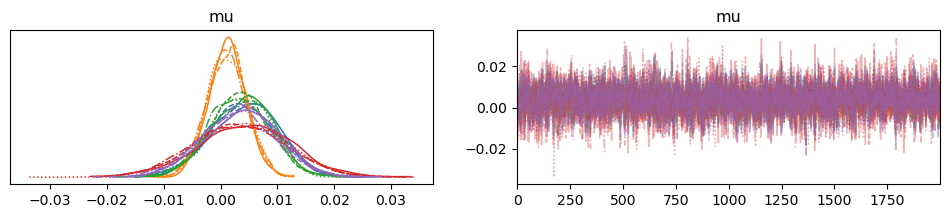

In [74]:
az.plot_trace(trace_normal)

We can also add a prior for the covariance of returns:

$\mu \sim N(\Pi, \tau \Sigma)$,

$Q|\mu \sim N(P\mu, \Omega)$,

$\Psi \sim \begin{pmatrix} \sigma_1 & 0 & \ddots \\ 0 & \ddots & 0 \\ \ddots & 0 & \sigma_5 \end{pmatrix} P \begin{pmatrix} \sigma_1 & 0 & \ddots \\ 0 & \ddots & 0 \\ \ddots & 0 & \sigma_5 \end{pmatrix}$,

$\sigma_i \sim HalfCauchy(1)$,

$P \sim LKJCorr(1)$,

$r \sim N(\mu, \Psi)$.

In [76]:
with pm.Model() as model_normal_cov:
    mu = pm.MvNormal('mu', mu = Pi, cov = (tau * Sigma), shape = 5)
    Q_p = pm.MvNormal('Q', mu = pm.math.dot(P, mu), cov = Omega, observed = Q, shape = 3)

    sd_0 = pm.HalfCauchy.dist(beta=1)
    chol, corr, sd = pm.LKJCholeskyCov('Psi', n=5, eta=1, sd_dist=sd_0, compute_corr=True)
    
    r = pm.MvNormal('returns', mu = mu, chol = chol, observed = data.pct_change().dropna().values)

    trace_normal_cov = pm.sample(2000, tune=1000, target_accept=0.8, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, Psi]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 365 seconds.


In [77]:
az.summary(trace_normal_cov, var_names=["mu","Psi_stds","Psi_corr"])

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.001,0.000,0.000,0.001,0.0,0.0,4546.0,5619.0,1.0
mu[1],0.000,0.000,-0.000,0.000,0.0,0.0,9187.0,5719.0,1.0
mu[2],0.001,0.000,0.000,0.001,0.0,0.0,3820.0,4662.0,1.0
mu[3],0.000,0.000,-0.001,0.001,0.0,0.0,4987.0,5529.0,1.0
mu[4],0.001,0.000,-0.000,0.001,0.0,0.0,4016.0,4739.0,1.0
Psi_stds[0],0.013,0.000,0.013,0.014,0.0,0.0,5562.0,5714.0,1.0
Psi_stds[1],0.003,0.000,0.003,0.003,0.0,0.0,9893.0,6010.0,1.0
Psi_stds[2],0.011,0.000,0.011,0.012,0.0,0.0,4419.0,4376.0,1.0
Psi_stds[3],0.020,0.000,0.019,0.020,0.0,0.0,6336.0,6218.0,1.0
Psi_stds[4],0.015,0.000,0.014,0.015,0.0,0.0,5088.0,5531.0,1.0


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'Psi_stds'}>,
        <Axes: title={'center': 'Psi_stds'}>]], dtype=object)

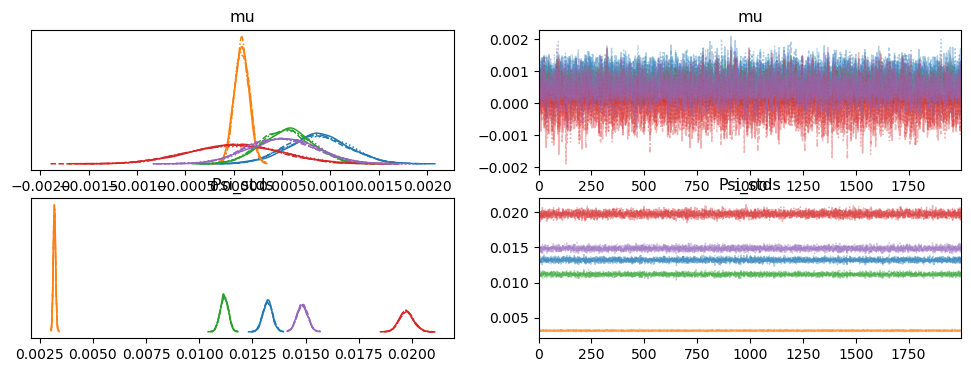

In [78]:
az.plot_trace(trace_normal_cov, var_names=["mu","Psi_stds"])

We can even suppose returns follow a Student's t-distribution, instead of a Gaussian, and put a prior on the degrees of freedom parameter:

$\mu \sim N(\Pi, \tau \Sigma)$,

$Q|\mu \sim N(P\mu, \Omega)$,

$\Psi \sim \begin{pmatrix} \sigma_1 & 0 & \ddots \\ 0 & \ddots & 0 \\ \ddots & 0 & \sigma_5 \end{pmatrix} P \begin{pmatrix} \sigma_1 & 0 & \ddots \\ 0 & \ddots & 0 \\ \ddots & 0 & \sigma_5 \end{pmatrix}$,

$\sigma_i \sim HalfCauchy(1)$,

$P \sim LKJCorr(1)$,

$\nu \sim Gamma(2, 10)$,

$r \sim t(\mu, \Psi, \nu)$.

In [79]:
with pm.Model() as model_t:
    mu = pm.MvNormal('mu', mu = Pi, cov = (tau * Sigma), shape = 5)
    Q_p = pm.MvNormal('Q', mu = pm.math.dot(P, mu), cov = Omega, observed = Q, shape = 3)
    
    sd_0 = pm.HalfCauchy.dist(beta=1)
    chol, corr, sd = pm.LKJCholeskyCov('Psi', n=5, eta=1, sd_dist=sd_0, compute_corr=True)
    
    nu = pm.Gamma('nu', alpha = 2, beta = 10)
    
    r = pm.MvStudentT('returns', nu = nu, mu = mu, chol = chol, observed = data.pct_change().dropna().values)

    trace_t = pm.sample(2000, tune=1000, target_accept=0.8, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, Psi, nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 391 seconds.


In [80]:
az.summary(trace_t, var_names=['nu',"mu","Psi_stds","Psi_corr"])

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,3.668,0.172,3.350,3.991,0.002,0.001,6850.0,5805.0,1.0
mu[0],0.001,0.000,0.001,0.002,0.000,0.000,4934.0,5170.0,1.0
mu[1],0.000,0.000,-0.000,0.000,0.000,0.000,11363.0,5926.0,1.0
mu[2],0.001,0.000,0.001,0.001,0.000,0.000,4004.0,5248.0,1.0
mu[3],-0.000,0.000,-0.001,0.000,0.000,0.000,6011.0,6229.0,1.0
mu[4],0.001,0.000,0.000,0.001,0.000,0.000,4356.0,5598.0,1.0
Psi_stds[0],0.009,0.000,0.008,0.009,0.000,0.000,4502.0,5562.0,1.0
Psi_stds[1],0.002,0.000,0.002,0.002,0.000,0.000,8619.0,6171.0,1.0
Psi_stds[2],0.007,0.000,0.007,0.007,0.000,0.000,3647.0,5022.0,1.0
Psi_stds[3],0.013,0.000,0.012,0.013,0.000,0.000,4492.0,5511.0,1.0


array([[<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'Psi_stds'}>,
        <Axes: title={'center': 'Psi_stds'}>]], dtype=object)

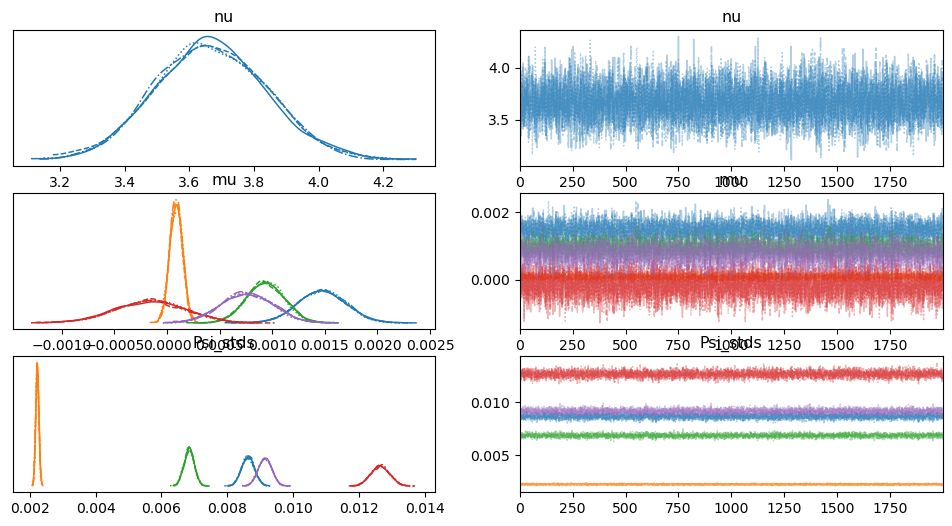

In [81]:
az.plot_trace(trace_t, var_names=['nu',"mu","Psi_stds"])

As the MCMC gives us the whole posterior distribution of the parameters, we can make use of statistics such as the posterior means or medians, and plug them into the mean-variance optimizer to obtain portfolio weights.

## Additional references for this section

Idzorek, T. (2007). A step-by-step guide to the Black-Litterman model: Incorporating user-specified confidence levels. In *Forecasting expected returns in the financial markets* (pp. 17-38). Academic Press.

Walters, J. (2014). The Black-Litterman Model in Detail. (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1314585)

Schepel, J.F. (2019), Bayesian Extensions of the Black-Litterman Model. (https://thesis.eur.nl/pub/49562/20190827-Final-thesis-J.F.-Schepel-483851js-.pdf)